#       **BREAST CANCER DETECTION USING DEEP LEARNING**






[Click to see Data Set](https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images)

## 1. Importing the necessary libraries 


In [1]:
#Import the necessary libraries first

import tensorflow as tf
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path

from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam


## 2. Loading Dataset and setting file directory

In [2]:
#Connect to Google Drive

from google.colab import drive
drive.mount('/content/drive')

#Path of our Data Set
#Can see the 2 type of split data 
#10264 is a limited path folder of a large data set

data = '/content/drive/MyDrive/10264'
No_breast_cancer = '/content/drive/MyDrive/10264/0'
Yes_breast_cancer = '/content/drive/MyDrive/10264/1'

#To specify the path in your google drive

import os
Root = "/content/drive/MyDrive/10264"
os.chdir(Root)

Mounted at /content/drive


## 3. Checking the number of files,Images or levels present 

In [3]:
#Check how many files,Images or levels are present
#For append the file path and names 
dirlist=[No_breast_cancer, Yes_breast_cancer]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  1204    labels:  1204


## 4. Creating DataFrame from the images

In [4]:
#Convert to the data frame
#for that we are using only 1204 images(just for testing)
 
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(1204,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/content/drive/MyDrive/10264/0/10264_idx5_x110...,No
1,/content/drive/MyDrive/10264/0/10264_idx5_x101...,No
2,/content/drive/MyDrive/10264/0/10264_idx5_x101...,No
3,/content/drive/MyDrive/10264/0/10264_idx5_x101...,No
4,/content/drive/MyDrive/10264/0/10264_idx5_x110...,No


## 5. Checking dataset is balanced or not 

In [5]:
#Check the data set is balance or not

print(df['labels'].value_counts())

No     617
Yes    587
Name: labels, dtype: int64


## 6. Visualization of the dataset 

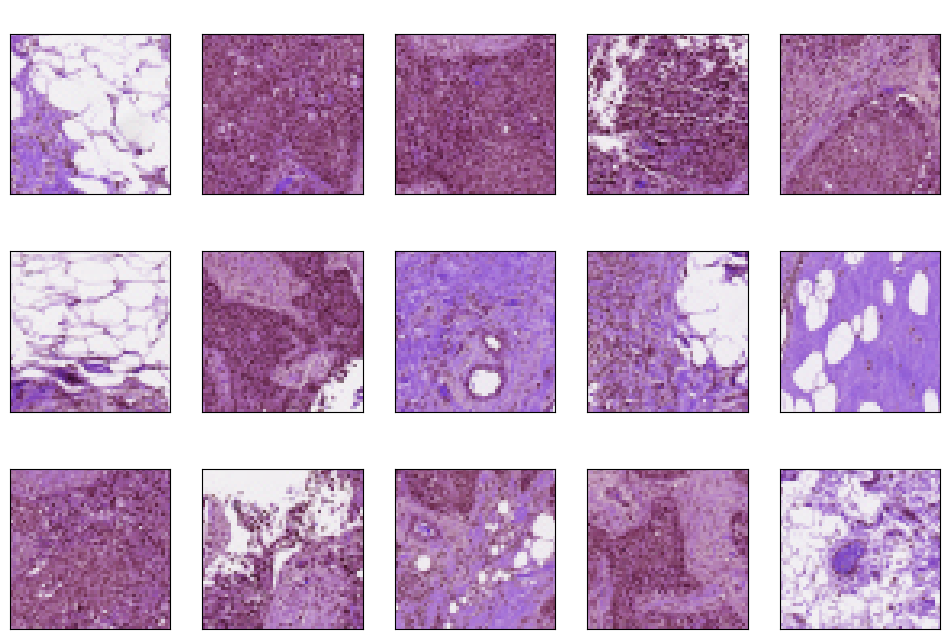

In [6]:
#visualize the data set to (Checking the category)

plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

## 7. Spliting the dataset into training,testing and validation dataset

In [7]:
#Doing the Train and Test split
'''Split train data into two part one is Train one is Validation  '''

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (1028, 2)
test set shape: (61, 2)
validation set shape: (115, 2)


## 8. Creating image data generator for each set 

In [8]:
#image data generatation 

train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)
#Creating Set
 
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 32,                     #image size is 224
                                              class_mode = 'binary', shuffle = True)                        # We are dealing with multiple Binary class classification problem 
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(224,224), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 1028 validated image filenames belonging to 2 classes.
Found 115 validated image filenames belonging to 2 classes.
Found 61 validated image filenames belonging to 2 classes.


## 9. Using different pretrained-models for comparison purpose


# **ResNet50V2**

In [9]:
from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet",             # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)                                   # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))


# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.


x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

94668760/94668760 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable

### Save the best out of the data

In [10]:
#Save the best out of the data

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]





model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 10, 
                    callbacks = [callbacks], verbose = 1)

Epoch 1/10
33/33 [==============================] - 289s 8s/step - loss: 0.7122 - accuracy: 0.5642 - val_loss: 0.6069 - val_accuracy: 0.7043
Epoch 2/10
33/33 [==============================] - 19s 571ms/step - loss: 0.6334 - accuracy: 0.6274 - val_loss: 0.5722 - val_accuracy: 0.6783
Epoch 3/10
33/33 [==============================] - 19s 564ms/step - loss: 0.5907 - accuracy: 0.6858 - val_loss: 0.5200 - val_accuracy: 0.7826
Epoch 4/10
33/33 [==============================] - 19s 565ms/step - loss: 0.5441 - accuracy: 0.7286 - val_loss: 0.4995 - val_accuracy: 0.7739
Epoch 5/10
33/33 [==============================] - 19s 575ms/step - loss: 0.5333 - accuracy: 0.7558 - val_loss: 0.4612 - val_accuracy: 0.8609
Epoch 6/10
33/33 [==============================] - 19s 567ms/step - loss: 0.5107 - accuracy: 0.7617 - val_loss: 0.4481 - val_accuracy: 0.8609
Epoch 7/10
33/33 [==============================] - 19s 581ms/step - loss: 0.4742 - accuracy: 0.7986 - val_loss: 0.4425 - val_accuracy: 0.8348
E

### Visualization

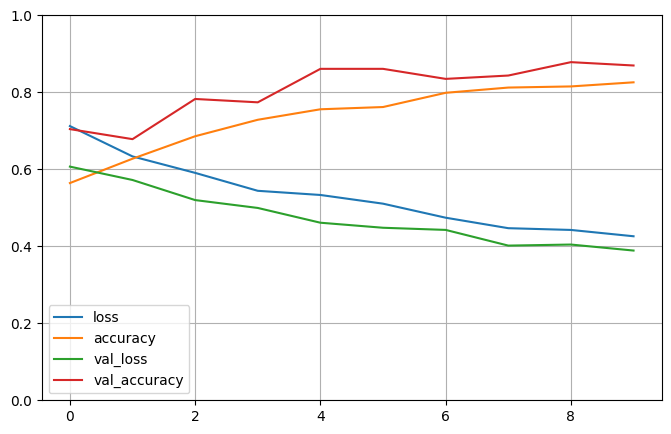

In [11]:
#Visualization

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### Fitting the model and making prediction

In [13]:
# Fit the model
#history = model.fit(train_gen, epochs=5, validation_data=val_gen, callbacks=callbacks)

# Evaluate the model on test set
test_loss, test_acc = model.evaluate(test_gen)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Predict the classes of the test set
test_pred = model.predict(test_gen)
test_pred_classes = np.round(test_pred)


4/4 [==============================] - 9s 3s/step - loss: 0.4702 - accuracy: 0.8525
Test Loss: 0.4701937139034271
Test Accuracy: 0.8524590134620667
4/4 [==============================] - 1s 62ms/step


### visualization of the confusion matrix

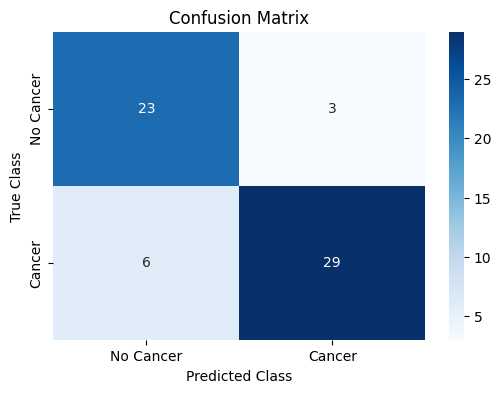

In [14]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_gen.classes, test_pred_classes)

# Visualize the confusion matrix
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['No Cancer', 'Cancer'], yticklabels=['No Cancer', 'Cancer'])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

### Classification report and Accuracy 

In [15]:
from sklearn.metrics import classification_report,accuracy_score
print(classification_report(test_gen.classes, test_pred_classes))
print(accuracy_score(test_gen.classes,test_pred_classes))

              precision    recall  f1-score   support

           0       0.79      0.88      0.84        26
           1       0.91      0.83      0.87        35

    accuracy                           0.85        61
   macro avg       0.85      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61

0.8524590163934426


# **VGG16**

In [16]:
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load the pre-trained VGG-16 model without the fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)  # Regularize with dropout
outputs = Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()


58889256/58889256 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable

### Save the best out of the data

In [43]:
#Save the best out of the data

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]





model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 10, 
                    callbacks = [callbacks], verbose = 1)

Epoch 1/10
33/33 [==============================] - 22s 557ms/step - loss: 0.7343 - accuracy: 0.4660 - val_loss: 0.6785 - val_accuracy: 0.5304
Epoch 2/10
33/33 [==============================] - 18s 558ms/step - loss: 0.7073 - accuracy: 0.5107 - val_loss: 0.6723 - val_accuracy: 0.6783
Epoch 3/10
33/33 [==============================] - 20s 593ms/step - loss: 0.6924 - accuracy: 0.5253 - val_loss: 0.6663 - val_accuracy: 0.7478
Epoch 4/10
33/33 [==============================] - 18s 557ms/step - loss: 0.6876 - accuracy: 0.5593 - val_loss: 0.6553 - val_accuracy: 0.8348
Epoch 5/10
33/33 [==============================] - 19s 573ms/step - loss: 0.6831 - accuracy: 0.5710 - val_loss: 0.6521 - val_accuracy: 0.8087
Epoch 6/10
33/33 [==============================] - 19s 576ms/step - loss: 0.6723 - accuracy: 0.6021 - val_loss: 0.6480 - val_accuracy: 0.7739
Epoch 7/10
33/33 [==============================] - 18s 531ms/step - loss: 0.6712 - accuracy: 0.6196 - val_loss: 0.6494 - val_accuracy: 0.7217

### Visualization

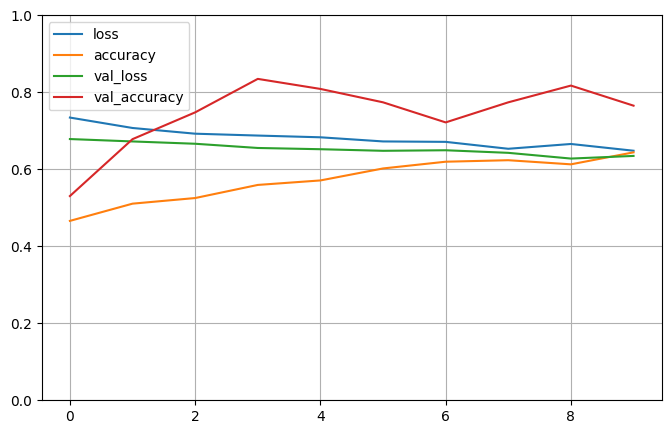

In [44]:
#Visualization

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### Evaluating the model on test set

In [45]:
# Fit the model
#history = model.fit(train_gen, epochs=5, validation_data=val_gen, callbacks=callbacks)

# Evaluate the model on test set
test_loss, test_acc = model.evaluate(test_gen)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Predict the classes of the test set
test_pred = model.predict(test_gen)
test_pred_classes = np.round(test_pred)


4/4 [==============================] - 0s 88ms/step - loss: 0.6259 - accuracy: 0.8361
Test Loss: 0.6258556246757507
Test Accuracy: 0.8360655903816223
4/4 [==============================] - 1s 74ms/step


### Visualization of the confusion matrix

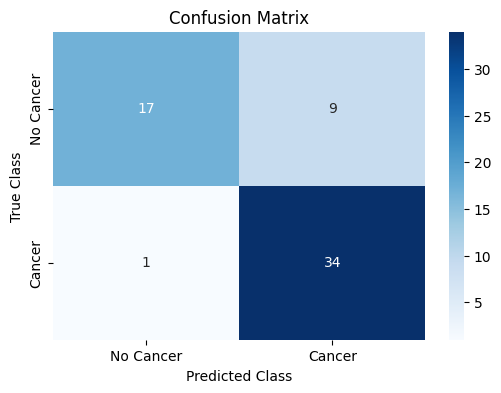

In [46]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_gen.classes, test_pred_classes)

# Visualize the confusion matrix
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['No Cancer', 'Cancer'], yticklabels=['No Cancer', 'Cancer'])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

### Classification report and Accuracy

In [47]:
from sklearn.metrics import classification_report,accuracy_score
print(classification_report(test_gen.classes, test_pred_classes))
print(accuracy_score(test_gen.classes,test_pred_classes))

              precision    recall  f1-score   support

           0       0.94      0.65      0.77        26
           1       0.79      0.97      0.87        35

    accuracy                           0.84        61
   macro avg       0.87      0.81      0.82        61
weighted avg       0.86      0.84      0.83        61

0.8360655737704918


# **GoogleNet**

In [22]:
from tensorflow import keras
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load the pre-trained GoogLeNet model without the fully connected layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)  # Regularize with dropout
outputs = Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()


87910968/87910968 [==============================] - 3s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainab

### Save the best out of the data 


In [23]:
#Save the best out of the data

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]





model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 10, 
                    callbacks = [callbacks], verbose = 1)

Epoch 1/10
33/33 [==============================] - 30s 707ms/step - loss: 0.8047 - accuracy: 0.4737 - val_loss: 0.7401 - val_accuracy: 0.4783
Epoch 2/10
33/33 [==============================] - 20s 605ms/step - loss: 0.6989 - accuracy: 0.5545 - val_loss: 0.6263 - val_accuracy: 0.5826
Epoch 3/10
33/33 [==============================] - 19s 571ms/step - loss: 0.6326 - accuracy: 0.6255 - val_loss: 0.5891 - val_accuracy: 0.6609
Epoch 4/10
33/33 [==============================] - 19s 586ms/step - loss: 0.6059 - accuracy: 0.6634 - val_loss: 0.5525 - val_accuracy: 0.7565
Epoch 5/10
33/33 [==============================] - 19s 566ms/step - loss: 0.5479 - accuracy: 0.7198 - val_loss: 0.5095 - val_accuracy: 0.7913
Epoch 6/10
33/33 [==============================] - 20s 603ms/step - loss: 0.5161 - accuracy: 0.7461 - val_loss: 0.4722 - val_accuracy: 0.7913
Epoch 7/10
33/33 [==============================] - 19s 586ms/step - loss: 0.4844 - accuracy: 0.7831 - val_loss: 0.4642 - val_accuracy: 0.7913

### Visualization

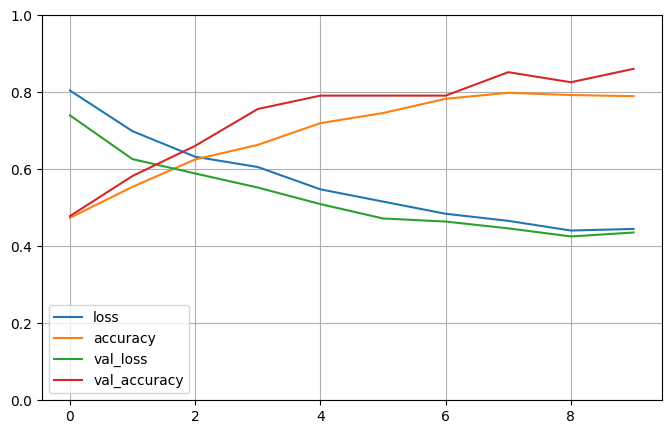

In [24]:
#Visualization

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### Evaluating the model on test Set

In [25]:
# Fit the model
#history = model.fit(train_gen, epochs=5, validation_data=val_gen, callbacks=callbacks)

# Evaluate the model on test set
test_loss, test_acc = model.evaluate(test_gen)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Predict the classes of the test set
test_pred = model.predict(test_gen)
test_pred_classes = np.round(test_pred)


4/4 [==============================] - 1s 429ms/step - loss: 0.6063 - accuracy: 0.7049
Test Loss: 0.6062881946563721
Test Accuracy: 0.7049180269241333
4/4 [==============================] - 2s 58ms/step


### Visualization of the confusion matrix

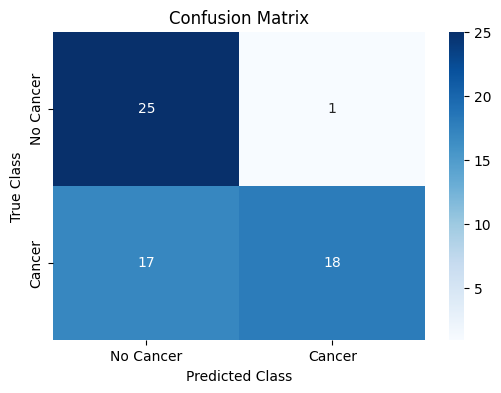

In [26]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_gen.classes, test_pred_classes)

# Visualize the confusion matrix
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['No Cancer', 'Cancer'], yticklabels=['No Cancer', 'Cancer'])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

### Classification report and Accuracy

In [27]:
from sklearn.metrics import classification_report,accuracy_score
print(classification_report(test_gen.classes, test_pred_classes))
print(accuracy_score(test_gen.classes,test_pred_classes))

              precision    recall  f1-score   support

           0       0.60      0.96      0.74        26
           1       0.95      0.51      0.67        35

    accuracy                           0.70        61
   macro avg       0.77      0.74      0.70        61
weighted avg       0.80      0.70      0.70        61

0.7049180327868853


# **AlexNet**

In [48]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

# Define the AlexNet model
model = Sequential()
model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(384, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(384, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))  # Assuming 1000 classes in ImageNet
model.add(Dense(1, activation='sigmoid'))  # Modify for your specific task

# Load pre-trained weights
#model.load_weights('path_to_weights')  # Replace 'path_to_weights' with the path to your pre-trained weights

# Freeze the base model
model.layers[0].trainable = False

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_99 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 26, 26, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_100 (Conv2D)         (None, 22, 22, 256)       614656    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 10, 10, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_101 (Conv2D)         (None, 8, 8, 384)         885120    
                                                                 
 conv2d_102 (Conv2D)         (None, 6, 6, 384)        

### Save the best out of the data

In [49]:
#Save the best out of the data

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]





model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 10, 
                    callbacks = [callbacks], verbose = 1)


Epoch 1/10
33/33 [==============================] - 25s 671ms/step - loss: 0.6713 - accuracy: 0.5224 - val_loss: 0.6324 - val_accuracy: 0.4957
Epoch 2/10
33/33 [==============================] - 18s 540ms/step - loss: 0.6624 - accuracy: 0.5603 - val_loss: 0.6921 - val_accuracy: 0.5043
Epoch 3/10
33/33 [==============================] - 20s 622ms/step - loss: 0.6213 - accuracy: 0.6381 - val_loss: 0.3470 - val_accuracy: 0.9043
Epoch 4/10
33/33 [==============================] - 22s 684ms/step - loss: 0.3529 - accuracy: 0.8658 - val_loss: 0.3086 - val_accuracy: 0.8522
Epoch 5/10
33/33 [==============================] - 21s 653ms/step - loss: 0.2839 - accuracy: 0.8998 - val_loss: 0.4109 - val_accuracy: 0.8000
Epoch 6/10
33/33 [==============================] - 20s 617ms/step - loss: 0.3040 - accuracy: 0.8988 - val_loss: 0.2599 - val_accuracy: 0.8870
Epoch 7/10
33/33 [==============================] - 24s 749ms/step - loss: 0.2755 - accuracy: 0.9105 - val_loss: 0.2021 - val_accuracy: 0.9304

### Visualization

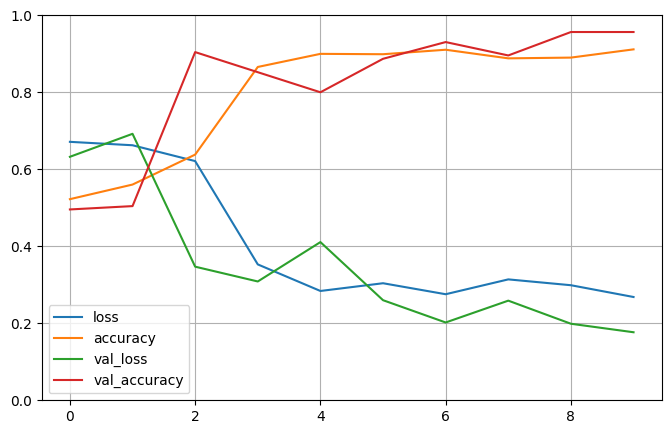

In [50]:
#Visualization

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### Evaluating the model on test set

In [51]:
# Fit the model
#history = model.fit(train_gen, epochs=5, validation_data=val_gen, callbacks=callbacks)

# Evaluate the model on test set
test_loss, test_acc = model.evaluate(test_gen)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Predict the classes of the test set
test_pred = model.predict(test_gen)
test_pred_classes = np.round(test_pred)


4/4 [==============================] - 0s 43ms/step - loss: 0.2038 - accuracy: 0.9508
Test Loss: 0.2038431167602539
Test Accuracy: 0.9508196711540222
4/4 [==============================] - 0s 43ms/step


### Visualization of the confusion matrix


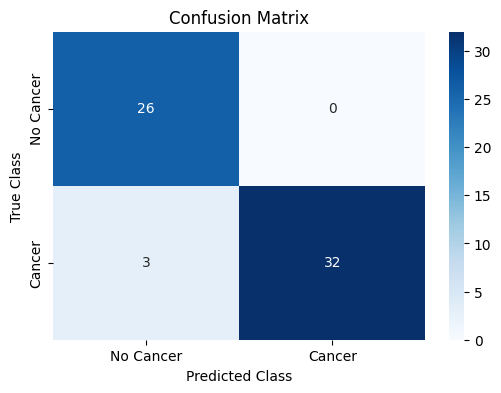

In [52]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_gen.classes, test_pred_classes)

# Visualize the confusion matrix
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['No Cancer', 'Cancer'], yticklabels=['No Cancer', 'Cancer'])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()



### Classification report and Accuracy

In [53]:
from sklearn.metrics import classification_report,accuracy_score
print(classification_report(test_gen.classes, test_pred_classes))
print(accuracy_score(test_gen.classes,test_pred_classes))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        26
           1       1.00      0.91      0.96        35

    accuracy                           0.95        61
   macro avg       0.95      0.96      0.95        61
weighted avg       0.96      0.95      0.95        61

0.9508196721311475


# **VGG19**

In [54]:
from tensorflow import keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load the pre-trained ResNet152 model without the fully connected layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)  # Regularize with dropout
outputs = Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_4   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 513       
                                                                 
Total params: 20,024,897
Trainable params: 513
Non-trainable params: 20,024,384
_____________________________________________

### Save the best out of the data


In [55]:
#Save the best out of the data

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]





model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 10, 
                    callbacks = [callbacks], verbose = 1)


Epoch 1/10
33/33 [==============================] - 22s 636ms/step - loss: 0.7437 - accuracy: 0.4854 - val_loss: 0.7173 - val_accuracy: 0.4348
Epoch 2/10
33/33 [==============================] - 18s 558ms/step - loss: 0.7321 - accuracy: 0.4893 - val_loss: 0.6987 - val_accuracy: 0.4261
Epoch 3/10
33/33 [==============================] - 20s 607ms/step - loss: 0.7099 - accuracy: 0.5214 - val_loss: 0.6933 - val_accuracy: 0.5217
Epoch 4/10
33/33 [==============================] - 19s 593ms/step - loss: 0.7028 - accuracy: 0.5253 - val_loss: 0.6932 - val_accuracy: 0.5043
Epoch 5/10
33/33 [==============================] - 19s 568ms/step - loss: 0.7134 - accuracy: 0.5136 - val_loss: 0.6836 - val_accuracy: 0.5304
Epoch 6/10
33/33 [==============================] - 22s 657ms/step - loss: 0.6917 - accuracy: 0.5525 - val_loss: 0.6765 - val_accuracy: 0.6174
Epoch 7/10
33/33 [==============================] - 20s 598ms/step - loss: 0.6815 - accuracy: 0.5691 - val_loss: 0.6627 - val_accuracy: 0.6957

### Visualization

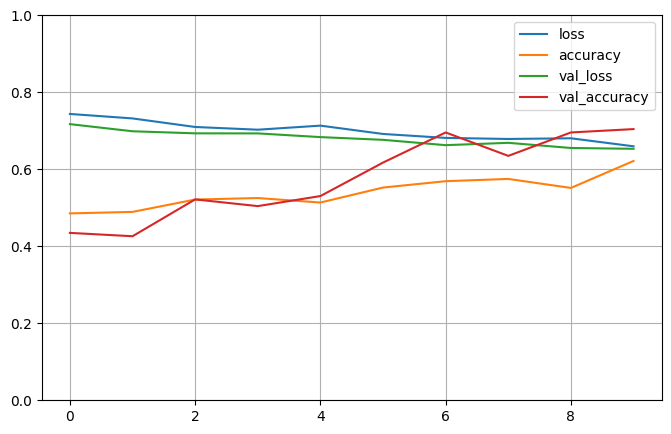

In [56]:
#Visualization

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### Evaluating the model on test set 



In [57]:
# Fit the model
#history = model.fit(train_gen, epochs=5, validation_data=val_gen, callbacks=callbacks)

# Evaluate the model on test set
test_loss, test_acc = model.evaluate(test_gen)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Predict the classes of the test set
test_pred = model.predict(test_gen)
test_pred_classes = np.round(test_pred)

4/4 [==============================] - 0s 93ms/step - loss: 0.6430 - accuracy: 0.7541
Test Loss: 0.6429980397224426
Test Accuracy: 0.7540983557701111
4/4 [==============================] - 0s 73ms/step


### Visualization of the confusion matrix



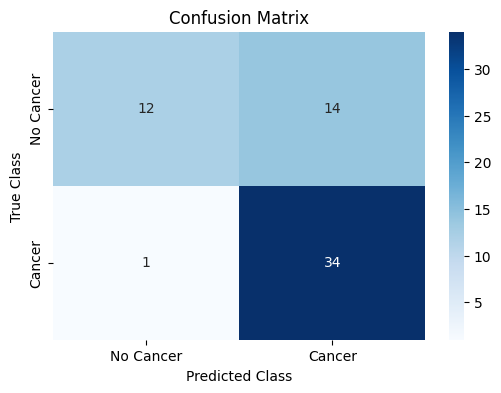

In [58]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_gen.classes, test_pred_classes)

# Visualize the confusion matrix
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['No Cancer', 'Cancer'], yticklabels=['No Cancer', 'Cancer'])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

### Classification report and Accuracy

In [59]:
from sklearn.metrics import classification_report,accuracy_score
print(classification_report(test_gen.classes, test_pred_classes))
print(accuracy_score(test_gen.classes,test_pred_classes))


              precision    recall  f1-score   support

           0       0.92      0.46      0.62        26
           1       0.71      0.97      0.82        35

    accuracy                           0.75        61
   macro avg       0.82      0.72      0.72        61
weighted avg       0.80      0.75      0.73        61

0.7540983606557377


#### **After comparing the performance of various deep learning models including ResNet50V2, VGG16, GoogleNet, AlexNet, and VGG19, we have determined that AlexNet achieves the highest accuracy on our dataset, reaching an impressive 95.08%.**